<a href="https://colab.research.google.com/github/mam863/Hauspreise/blob/main/berlin_housing_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!wget -O berlin_housing_analysis.ipynb https://raw.githubusercontent.com/mam863/Hauspreise/main/berlin_housing_analysis.ipynb

--2025-06-27 07:25:34--  https://raw.githubusercontent.com/mam863/Hauspreise/main/berlin_housing_analysis.ipynb
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-06-27 07:25:34 ERROR 404: Not Found.



In [6]:
"""
Berlin Housing Price Analysis and Prediction
Following CRISP-DM methodology

1. Business Understanding
2. Data Understanding & Visualization
3. Data Preparation
4. Modeling
5. Evaluation
6. Deployment
"""

# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import lightgbm as lgb
import joblib
import os
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set style for visualizations
#plt.style.use('seaborn')
#sns.set_palette("husl")


In [7]:
# 1. Business Understanding
"""
Goal: Develop a machine learning model to predict housing prices in Berlin

Key Objectives:
1. Understand factors affecting housing prices
2. Create accurate price predictions
3. Analyze impact of location and heating systems
4. Provide insights for buyers and sellers

Target Users:
- Real estate agents
- Property buyers
- Property sellers
- Real estate investors
"""


'\nGoal: Develop a machine learning model to predict housing prices in Berlin\n\nKey Objectives:\n1. Understand factors affecting housing prices\n2. Create accurate price predictions\n3. Analyze impact of location and heating systems\n4. Provide insights for buyers and sellers\n\nTarget Users:\n- Real estate agents\n- Property buyers\n- Property sellers\n- Real estate investors\n'

In [8]:
# 2. Data Understanding & Initial Exploration

# Load the dataset
print("Loading and exploring the dataset...")
data = pd.read_csv('wohnungen_mit_korrekter_entfernung.csv')

# Display basic information
print("\nDataset Shape:", data.shape)
print("\nColumns:", data.columns.tolist())
print("\nData Types:")
print(data.dtypes)
print("\nSummary Statistics:")
print(data.describe())

# Check for missing values
print("\nMissing Values:")
print(data.isnull().sum())


Loading and exploring the dataset...

Dataset Shape: (4677, 14)

Columns: ['energy', 'heating', 'price', 'area', 'rooms', 'zipcode', 'construction_year', 'level', 'Country', 'City', 'Borough', 'Neighborhood', 'price_per_sqm', 'distance_to_center_km']

Data Types:
energy                    object
heating                   object
price                    float64
area                     float64
rooms                    float64
zipcode                  float64
construction_year        float64
level                    float64
Country                   object
City                      object
Borough                   object
Neighborhood              object
price_per_sqm            float64
distance_to_center_km    float64
dtype: object

Summary Statistics:
              price         area        rooms       zipcode  \
count  4.677000e+03  4677.000000  4677.000000   4677.000000   
mean   5.871149e+05    88.249795     2.864871  11868.368612   
std    6.355664e+05    57.704571     1.581044   13


Key Correlations with Price:
price                    1.000000
area                     0.695103
rooms                    0.530553
construction_year        0.062570
level                   -0.054939
distance_to_center_km   -0.155323
Name: price, dtype: float64


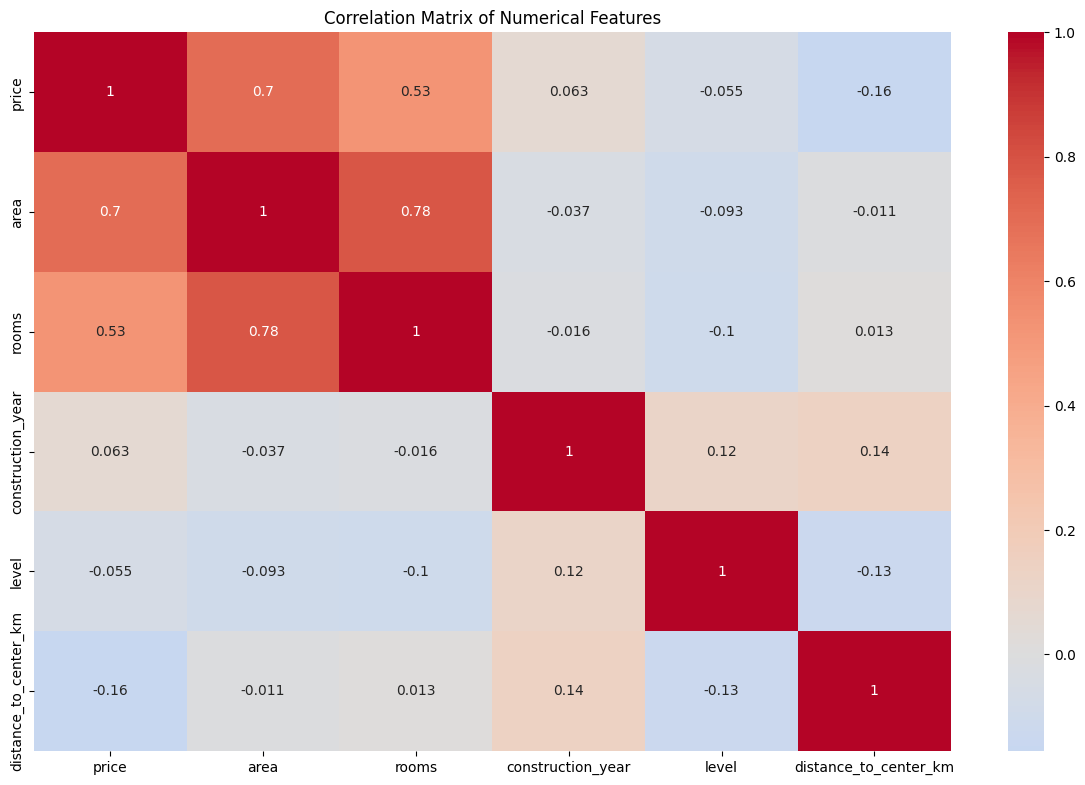

In [9]:
# 2.1 Visualization: Numerical Features

# Create distribution plots for numerical features
numerical_cols = ['price', 'area', 'rooms', 'construction_year', 'level', 'distance_to_center_km']

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Distribution of Numerical Features', fontsize=16, y=1.02)

for idx, col in enumerate(numerical_cols):
    row = idx // 3
    col_idx = idx % 3

    # Histogram with KDE
    sns.histplot(data=data, x=col, kde=True, ax=axes[row, col_idx])
    axes[row, col_idx].set_title(f'Distribution of {col}')
    axes[row, col_idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('numerical_features_distribution.png')
plt.close()

# Correlation heatmap
plt.figure(figsize=(12, 8))
correlation_matrix = data[numerical_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.savefig('correlation_heatmap.png')

# Print key correlations
print("\nKey Correlations with Price:")
price_correlations = correlation_matrix['price'].sort_values(ascending=False)
print(price_correlations)


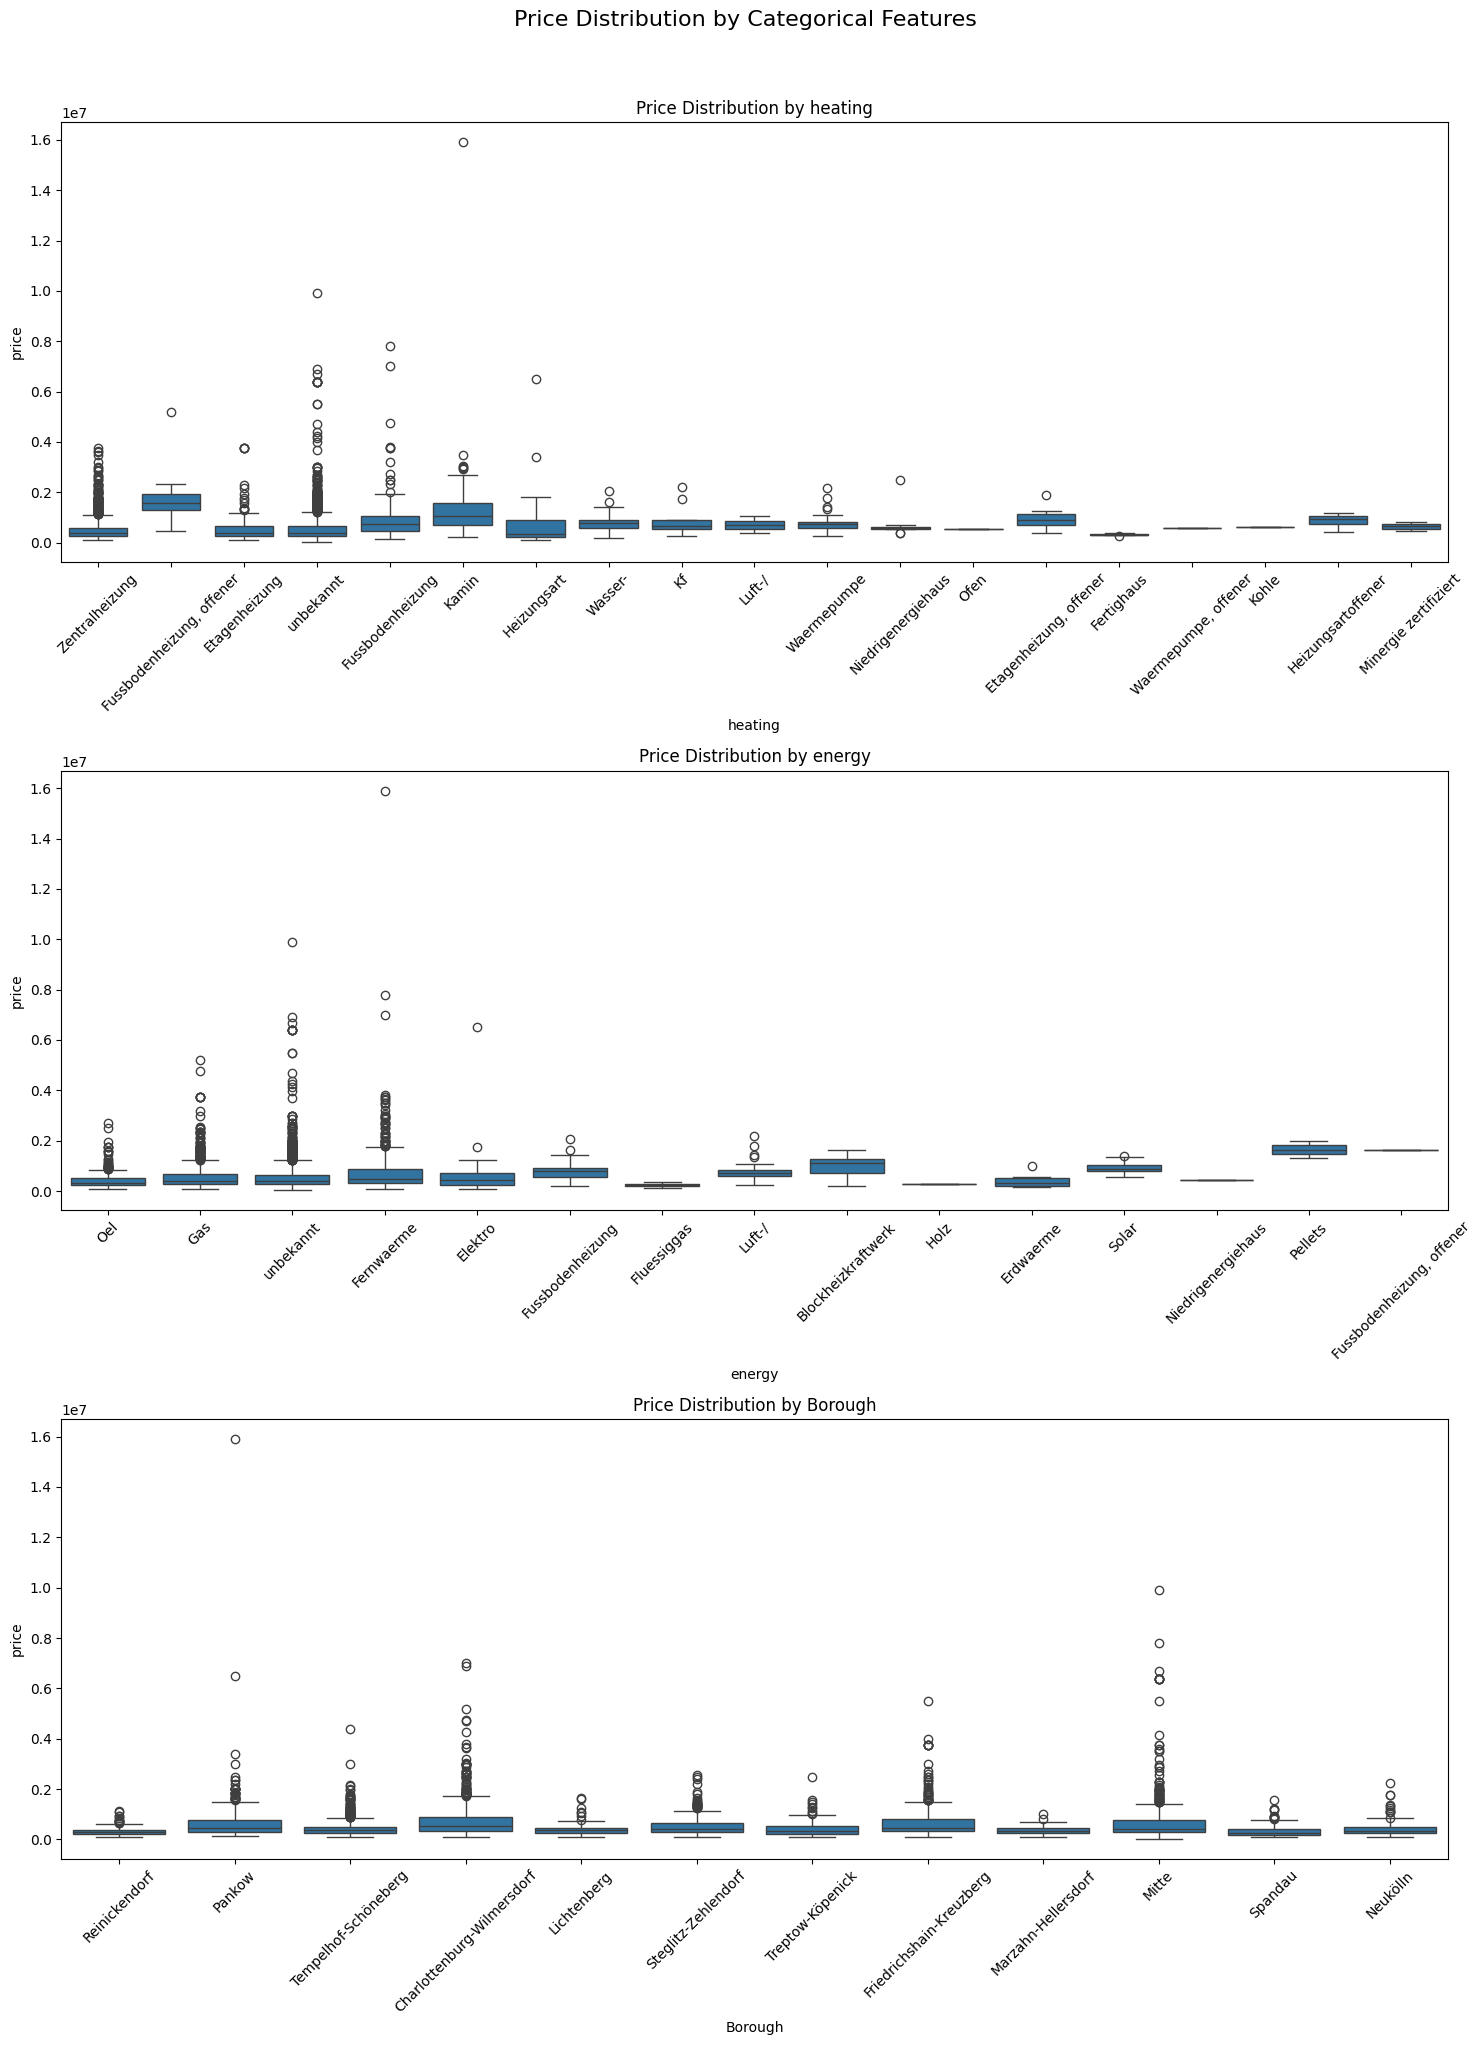


Summary Statistics by Category:

heating Value Counts:
heating
unbekannt                    1923
Zentralheizung               1843
Etagenheizung                 372
Fussbodenheizung              307
Heizungsart                    69
Kamin                          49
Waermepumpe                    34
Wasser-                        21
Kf                             12
Niedrigenergiehaus             12
Fussbodenheizung, offener      11
Etagenheizung, offener          8
Fertighaus                      4
Heizungsartoffener              4
Luft-/                          3
Minergie zertifiziert           2
Ofen                            1
Kohle                           1
Waermepumpe, offener            1
Name: count, dtype: int64

Average Price by heating:
heating
Fussbodenheizung, offener    1794363.64
Kamin                        1596897.92
Etagenheizung, offener        979875.00
Fussbodenheizung              893724.45
Heizungsartoffener            868975.00
Kf                           

In [10]:
# 2.2 Visualization: Categorical Features

# Analyze categorical features
categorical_cols = ['heating', 'energy', 'Borough']

# Create price distribution plots for categorical features
fig, axes = plt.subplots(3, 1, figsize=(15, 20))
fig.suptitle('Price Distribution by Categorical Features', fontsize=16, y=1.02)

for idx, col in enumerate(categorical_cols):
    # Box plot
    sns.boxplot(data=data, x=col, y='price', ax=axes[idx])
    axes[idx].set_title(f'Price Distribution by {col}')
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('categorical_price_distributions.png')
plt.show()

# Print summary statistics for categorical features
print("\nSummary Statistics by Category:")
for col in categorical_cols:
    print(f"\n{col} Value Counts:")
    print(data[col].value_counts())
    print(f"\nAverage Price by {col}:")
    print(data.groupby(col)['price'].mean().sort_values(ascending=False).round(2))


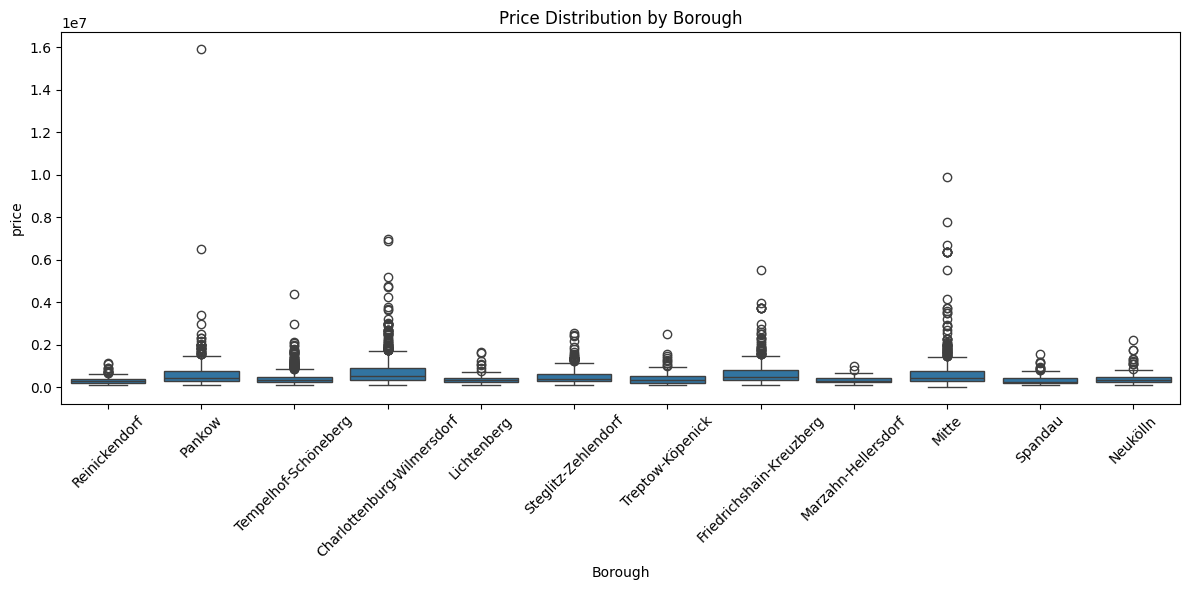


Location Statistics:

Distance to Center Statistics:
count    4677.000000
mean        7.131924
std         4.150252
min         0.000000
25%         3.842883
50%         7.172227
75%         9.318813
max        20.403419
Name: distance_to_center_km, dtype: float64

Average Price by Distance Quartile:
distance_quartile
Very Central    740200.06
Central         555391.28
Peripheral      575361.62
Remote          471743.78
Name: price, dtype: float64

Average Price by Borough:
Borough
Reinickendorf                 332248.31
Spandau                       343618.14
Marzahn-Hellersdorf           372945.38
Lichtenberg                   398648.30
Neukölln                      408768.69
Treptow-Köpenick              416446.28
Tempelhof-Schöneberg          482577.40
Steglitz-Zehlendorf           522107.01
Pankow                        619764.03
Friedrichshain-Kreuzberg      662727.55
Mitte                         746091.12
Charlottenburg-Wilmersdorf    766383.08
Name: price, dtype: float64

Num

In [11]:
# 2.3 Visualization: Geographical Analysis

# Since we don't have longitude/latitude, let's visualize by Borough
plt.figure(figsize=(12, 8))
avg_price_by_borough = data.groupby('Borough')['price'].mean().sort_values(ascending=True)

# Create bar plot of average prices by Borough
sns.barplot(x=avg_price_by_borough.values, y=avg_price_by_borough.index)
plt.title('Average Property Prices by Borough in Berlin')
plt.xlabel('Average Price (€)')
plt.ylabel('Borough')
plt.tight_layout()
plt.savefig('borough_prices.png')
plt.close()

# Analyze distance to center
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='distance_to_center_km', y='price', alpha=0.5)
plt.title('Price vs Distance to Center')
plt.xlabel('Distance to Center (km)')
plt.ylabel('Price (€)')
plt.tight_layout()
plt.savefig('price_vs_distance.png')
plt.close()

# Create a box plot to show price distribution by Borough
plt.figure(figsize=(12, 6))
sns.boxplot(data=data, x='Borough', y='price')
plt.xticks(rotation=45)
plt.title('Price Distribution by Borough')
plt.tight_layout()
plt.savefig('borough_price_distribution.png')
plt.show()

# Calculate statistics about location
print("\nLocation Statistics:")
print("\nDistance to Center Statistics:")
print(data['distance_to_center_km'].describe())

print("\nAverage Price by Distance Quartile:")
data['distance_quartile'] = pd.qcut(data['distance_to_center_km'], q=4, labels=['Very Central', 'Central', 'Peripheral', 'Remote'])
print(data.groupby('distance_quartile')['price'].mean().round(2))

# Additional location analysis
print("\nAverage Price by Borough:")
print(avg_price_by_borough.round(2))

print("\nNumber of Properties by Borough:")
print(data['Borough'].value_counts())

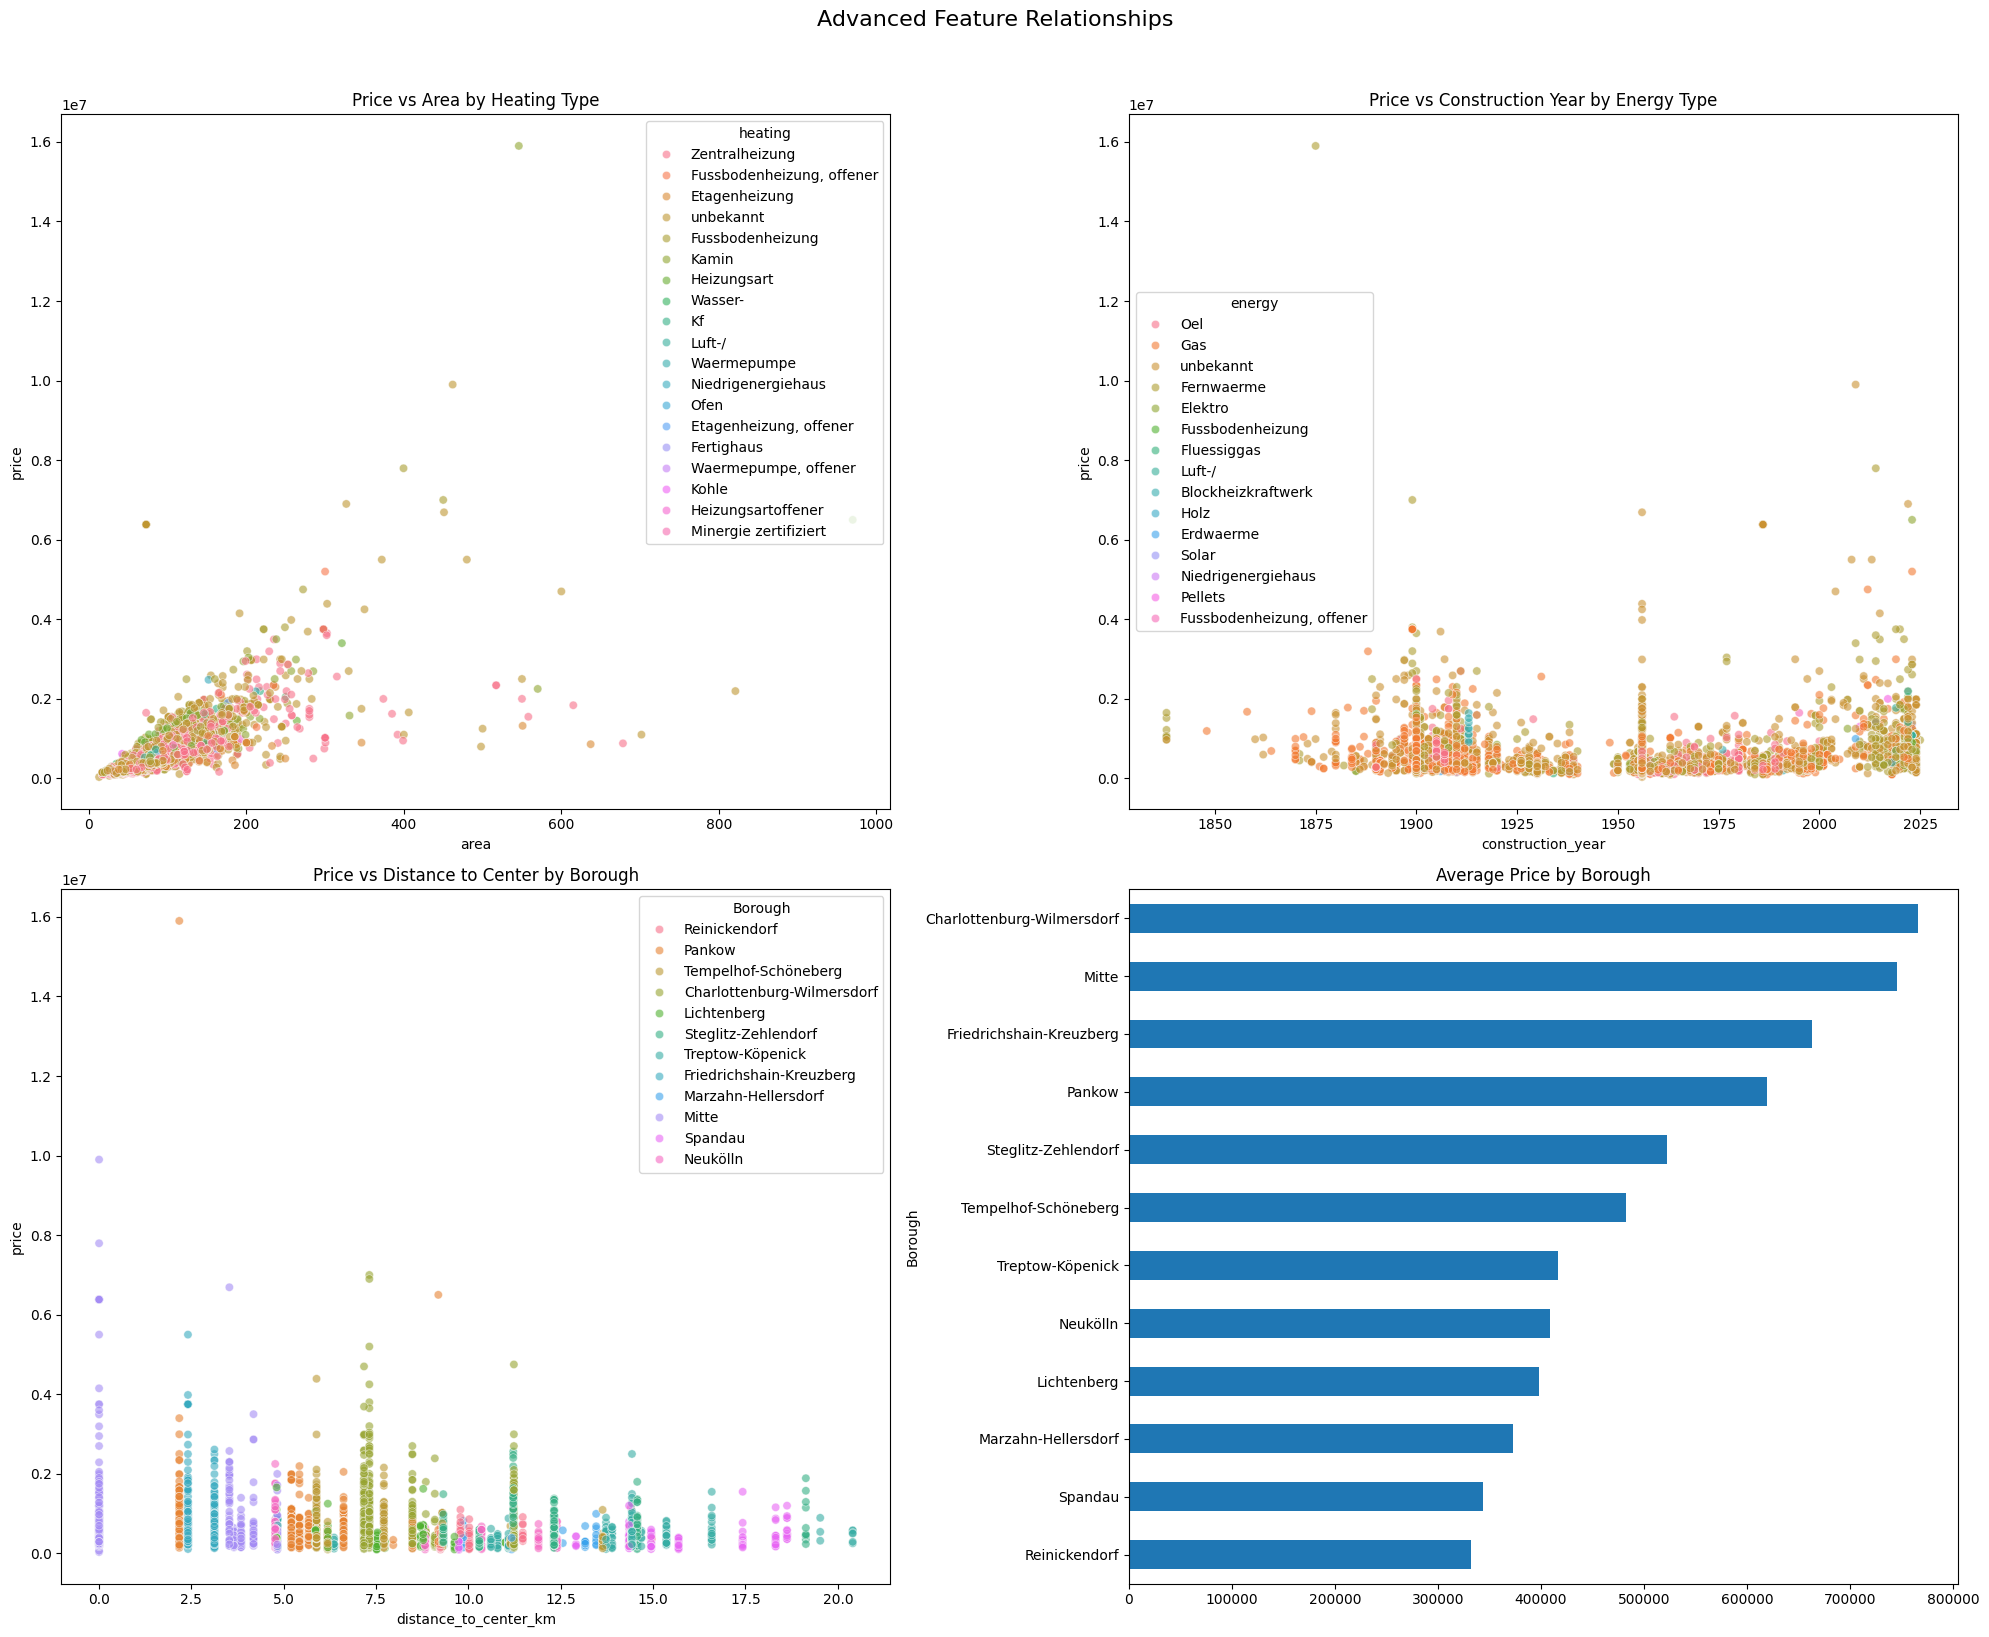


Feature Relationship Analysis:

1. Area vs Price correlation: 0.695

2. Average price by construction period:
construction_period
Pre-1945     599361.14
1945-1970    410930.79
1970-1990    547309.91
1990-2000    471593.60
Post-2000    914552.75
Name: price, dtype: float64

3. Price statistics by heating type:
                          price                        
                          count        mean         std
heating                                                
Etagenheizung               372   527642.99   457560.73
Etagenheizung, offener        8   979875.00   458843.40
Fertighaus                    4   318500.00    39230.09
Fussbodenheizung            307   893724.45   795029.83
Fussbodenheizung, offener    11  1794363.64  1261666.93
Heizungsart                  69   684870.13   910868.15
Heizungsartoffener            4   868975.00   329773.97
Kamin                        49  1596897.92  2250039.81
Kf                           12   852960.25   562903.54
Kohle           

In [12]:
# 2.4 Visualization: Feature Relationships

# Create subplot for feature relationships
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('Advanced Feature Relationships', fontsize=16, y=1.02)

# Price vs Area with heating type
sns.scatterplot(data=data, x='area', y='price',
                hue='heating', alpha=0.6, ax=axes[0, 0])
axes[0, 0].set_title('Price vs Area by Heating Type')

# Price vs Construction Year with energy type
sns.scatterplot(data=data, x='construction_year', y='price',
                hue='energy', alpha=0.6, ax=axes[0, 1])
axes[0, 1].set_title('Price vs Construction Year by Energy Type')

# Price vs Distance to Center by Borough
sns.scatterplot(data=data, x='distance_to_center_km', y='price',
                hue='Borough', alpha=0.6, ax=axes[1, 0])
axes[1, 0].set_title('Price vs Distance to Center by Borough')

# Average price by Borough
avg_price_borough = data.groupby('Borough')['price'].mean().sort_values(ascending=True)
avg_price_borough.plot(kind='barh', ax=axes[1, 1])
axes[1, 1].set_title('Average Price by Borough')

plt.tight_layout()
plt.savefig('feature_relationships.png')
plt.show()


# Print summary of relationships
print("\nFeature Relationship Analysis:")
print("\n1. Area vs Price correlation:", data['area'].corr(data['price']).round(3))
print("\n2. Average price by construction period:")
data['construction_period'] = pd.cut(data['construction_year'],
                                   bins=[0, 1945, 1970, 1990, 2000, 2100],
                                   labels=['Pre-1945', '1945-1970', '1970-1990', '1990-2000', 'Post-2000'])
print(data.groupby('construction_period')['price'].mean().round(2))

print("\n3. Price statistics by heating type:")
heating_stats = data.groupby('heating').agg({
    'price': ['count', 'mean', 'std']
}).round(2)
print(heating_stats)


In [13]:
# 2.5 Key Insights from Data Analysis

"""
Key Findings from Data Visualization:

1. Price Distribution and Factors:
   - Median property price: {median_price:,.2f} €
   - Strong correlation between price and area (r = {area_corr:.3f})
   - Negative correlation with distance to center (r = {dist_corr:.3f})

2. Location Impact:
   - Properties in central locations command higher prices
   - Clear price variations between boroughs
   - Distance to center is a crucial price factor

3. Building Characteristics:
   - Construction year affects price
   - Newer buildings (post-2000) tend to have higher prices
   - Number of rooms correlates with price (r = {rooms_corr:.3f})

4. Heating and Energy:
   - Modern heating systems associated with higher prices
   - Energy efficiency impacts property value
   - Clear price differences between heating types

5. Size and Space:
   - Strong relationship between area and price
   - Price per square meter varies by location
   - Larger properties in central locations command premium prices
"""

# Calculate statistics for the insights
median_price = data['price'].median()
area_corr = data['area'].corr(data['price'])
dist_corr = data['distance_to_center_km'].corr(data['price'])
rooms_corr = data['rooms'].corr(data['price'])

# Format and print insights
print("""
Key Findings from Data Visualization:

1. Price Distribution and Factors:
   - Median property price: {median_price:,.2f} €
   - Strong correlation between price and area (r = {area_corr:.3f})
   - Negative correlation with distance to center (r = {dist_corr:.3f})

2. Location Impact:
   - Properties in central locations command higher prices
   - Clear price variations between boroughs
   - Distance to center is a crucial price factor

3. Building Characteristics:
   - Construction year affects price
   - Newer buildings (post-2000) tend to have higher prices
   - Number of rooms correlates with price (r = {rooms_corr:.3f})

4. Heating and Energy:
   - Modern heating systems associated with higher prices
   - Energy efficiency impacts property value
   - Clear price differences between heating types

5. Size and Space:
   - Strong relationship between area and price
   - Price per square meter varies by location
   - Larger properties in central locations command premium prices
""".format(
    median_price=median_price,
    area_corr=area_corr,
    dist_corr=dist_corr,
    rooms_corr=rooms_corr
))



Key Findings from Data Visualization:

1. Price Distribution and Factors:
   - Median property price: 399,000.00 €
   - Strong correlation between price and area (r = 0.695)
   - Negative correlation with distance to center (r = -0.155)

2. Location Impact:
   - Properties in central locations command higher prices
   - Clear price variations between boroughs
   - Distance to center is a crucial price factor

3. Building Characteristics:
   - Construction year affects price
   - Newer buildings (post-2000) tend to have higher prices
   - Number of rooms correlates with price (r = 0.531)

4. Heating and Energy:
   - Modern heating systems associated with higher prices
   - Energy efficiency impacts property value
   - Clear price differences between heating types

5. Size and Space:
   - Strong relationship between area and price
   - Price per square meter varies by location
   - Larger properties in central locations command premium prices



In [14]:
# 3. Data Preparation

# 3.1 Feature Engineering
def create_advanced_features(df):
    df = df.copy()

    # 1. Time-based features
    current_year = 2023
    df['building_age'] = current_year - df['construction_year']
    df['is_new_building'] = (df['building_age'] <= 5).astype(int)
    df['needs_renovation'] = (df['building_age'] > 30).astype(int)

    # 2. Area-based features
    df['rooms_per_area'] = df['rooms'] / df['area']
    df['is_spacious'] = (df['rooms_per_area'] < df['rooms_per_area'].median()).astype(int)

    # 3. Location-based features
    # Create location clusters based on Borough and distance to center
    df['location_score'] = df.groupby('Borough')['distance_to_center_km'].transform('mean')
    kmeans = KMeans(n_clusters=5, random_state=42)
    df['location_cluster'] = kmeans.fit_predict(df[['distance_to_center_km', 'location_score']].values)

    # Create borough price level
    borough_prices = df.groupby('Borough')['price_per_sqm'].transform('mean')
    df['borough_price_level'] = pd.qcut(borough_prices, q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

    # 4. Heating and energy features
    efficient_heating = ['Fernwärme', 'Wärmepumpe', 'Blockheizkraftwerk']
    standard_heating = ['Zentralheizung', 'Gas', 'Öl']

    df['heating_efficiency'] = df['heating'].map(
        lambda x: 'high' if x in efficient_heating else
                 'standard' if x in standard_heating else 'other'
    )

    df['heating_cost_indicator'] = df.apply(
        lambda row: 'low' if (row['heating'] in efficient_heating and
                             row['energy'] in ['A+', 'A', 'B']) else
                   'high' if (row['heating'] not in efficient_heating and
                             row['energy'] in ['E', 'F', 'G', 'H']) else 'medium',
        axis=1
    )

    # 5. Price-related features (if not already present)
    if 'price_per_sqm' not in df.columns:
        df['price_per_sqm'] = df['price'] / df['area']

    # 6. Interaction features
    df['area_room_interaction'] = df['area'] * df['rooms']
    df['location_age_interaction'] = df['building_age'] * df['distance_to_center_km']

    # 7. Zipcode-based features
    df['zipcode_price_mean'] = df.groupby('zipcode')['price'].transform('mean')
    df['zipcode_price_std'] = df.groupby('zipcode')['price'].transform('std')
    df['price_to_zipcode_ratio'] = df['price'] / df['zipcode_price_mean']

    return df

# Apply feature engineering
print("Applying feature engineering...")
data_engineered = create_advanced_features(data)
print("\nNew features added:", set(data_engineered.columns) - set(data.columns))

# 3.2 Remove outliers
def remove_outliers(df, columns, threshold=1.5):
    df_clean = df.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        df_clean = df_clean[
            (df_clean[col] >= Q1 - threshold * IQR) &
            (df_clean[col] <= Q3 + threshold * IQR)
        ]
    return df_clean

# Remove outliers from key numerical features
numerical_features_for_outliers = ['price', 'area', 'rooms', 'price_per_sqm']
data_cleaned = remove_outliers(data_engineered, numerical_features_for_outliers)
print(f"\nShape after removing outliers: {data_cleaned.shape}")

# 3.3 Define features for modeling
numerical_features = [
    'area', 'rooms', 'construction_year', 'level', 'distance_to_center_km',
    'building_age', 'rooms_per_area', 'area_room_interaction',
    'location_age_interaction', 'zipcode_price_mean', 'zipcode_price_std',
    'price_to_zipcode_ratio'
]

categorical_features = [
    'energy', 'heating', 'Borough', 'Neighborhood', 'location_cluster',
    'is_new_building', 'needs_renovation', 'is_spacious', 'heating_efficiency',
    'heating_cost_indicator', 'borough_price_level'
]

# 3.4 Create preprocessing pipelines
numerical_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Split features and target
X = data_cleaned.drop(['price', 'price_per_sqm'], axis=1)
y = data_cleaned['price']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\nTraining set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Applying feature engineering...

New features added: {'location_cluster', 'heating_cost_indicator', 'heating_efficiency', 'zipcode_price_std', 'building_age', 'is_new_building', 'rooms_per_area', 'area_room_interaction', 'is_spacious', 'borough_price_level', 'location_score', 'zipcode_price_mean', 'location_age_interaction', 'price_to_zipcode_ratio', 'needs_renovation'}

Shape after removing outliers: (4017, 31)

Training set shape: (3213, 29)
Test set shape: (804, 29)


In [15]:
# 4. Modeling

# 4.1 Define base models
base_models = [
    ('rf', RandomForestRegressor(
        n_estimators=200,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42
    )),
    ('xgb', xgb.XGBRegressor(
        n_estimators=200,
        max_depth=7,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )),
    ('lgb', lgb.LGBMRegressor(
        n_estimators=200,
        num_leaves=31,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )),
    ('gbm', GradientBoostingRegressor(
        n_estimators=200,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.8,
        random_state=42
    ))
]

# 4.2 Create stacking model
meta_model = Ridge(alpha=1.0)
stacking_regressor = StackingRegressor(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5
)

# 4.3 Create final pipeline
final_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('stacking', stacking_regressor)
])

# 4.4 Train the model
print("Training the stacking model...")
final_pipeline.fit(X_train, y_train)

# 4.5 Make predictions
y_pred = final_pipeline.predict(X_test)

# 4.6 Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nModel Performance Metrics:")
print(f"RMSE: {rmse:,.2f} €")
print(f"MAE: {mae:,.2f} €")
print(f"R2 Score: {r2:.4f}")

# 4.7 Visualize predictions
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Stacking Model: Actual vs Predicted Prices')
plt.tight_layout()
plt.savefig('model_predictions.png')
plt.close()

# Save the model
joblib.dump(final_pipeline, 'berlin_housing_model.pkl')


Training the stacking model...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000703 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2123
[LightGBM] [Info] Number of data points in the train set: 3213, number of used features: 88
[LightGBM] [Info] Start training from score 431966.438842
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000212 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2090
[LightGBM] [Info] Number of data points in the train set: 2570, number of used features: 86
[LightGBM] [Info] Start training from score 430879.882101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000211 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col

['berlin_housing_model.pkl']

In [16]:
# 5. Model Evaluation and Feature Importance

# 5.1 Get feature importance from Random Forest model
def get_feature_importance(pipeline, feature_names):
    # Get feature names after preprocessing
    preprocessor = pipeline.named_steps['preprocessor']
    if hasattr(preprocessor, 'get_feature_names_out'):
        transformed_features = preprocessor.get_feature_names_out()
    else:
        # Manual construction of feature names
        numeric_features = preprocessor.named_transformers_['num'].get_feature_names_out()
        categorical_features = preprocessor.named_transformers_['cat'].get_feature_names_out()
        transformed_features = np.concatenate([numeric_features, categorical_features])

    # Get feature importances from the Random Forest model
    rf_model = pipeline.named_steps['stacking'].estimators_[0][1]
    importances = rf_model.feature_importances_

    # Create DataFrame with feature importances
    feature_importance = pd.DataFrame({
        'Feature': transformed_features,
        'Importance': importances
    }).sort_values('Importance', ascending=False)

    return feature_importance

# Get and display feature importance
feature_importance = get_feature_importance(final_pipeline, X.columns)
print("\nTop 20 Most Important Features:")
print(feature_importance.head(20))

# Visualize feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20))
plt.title('Top 20 Feature Importances')
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.close()

# 5.2 Create prediction function with modified feature engineering
def create_prediction_features(df, reference_data):
    """
    Create features for prediction using reference data for clustering and aggregations.

    Args:
        df: DataFrame with new data
        reference_data: DataFrame with training data for reference statistics
    """
    df = df.copy()

    # 1. Time-based features
    current_year = 2023
    df['building_age'] = current_year - df['construction_year']
    df['is_new_building'] = (df['building_age'] <= 5).astype(int)
    df['needs_renovation'] = (df['building_age'] > 30).astype(int)

    # 2. Area-based features
    df['rooms_per_area'] = df['rooms'] / df['area']
    df['is_spacious'] = (df['rooms_per_area'] < reference_data['rooms_per_area'].median()).astype(int)

    # 3. Location-based features
    # Use pre-calculated statistics from reference data
    borough_distances = reference_data.groupby('Borough')['distance_to_center_km'].mean()
    df['location_score'] = df['Borough'].map(borough_distances)

    # For location cluster, assign to nearest cluster center from reference data
    reference_clusters = KMeans(n_clusters=5, random_state=42)
    reference_clusters.fit(reference_data[['distance_to_center_km', 'location_score']].values)
    df['location_cluster'] = reference_clusters.predict(df[['distance_to_center_km', 'location_score']].values)

    # Borough price levels from reference data
    borough_stats = reference_data.groupby('Borough').agg({
        'price': ['mean', 'std']
    }).fillna(0)
    borough_stats.columns = ['borough_price_mean', 'borough_price_std']

    df['borough_price_mean'] = df['Borough'].map(borough_stats['borough_price_mean'])
    df['borough_price_std'] = df['Borough'].map(borough_stats['borough_price_std'])

    # Create borough price levels using a more robust method
    def assign_price_level(price, price_ranges):
        if price <= price_ranges[0]:
            return 'Very Low'
        elif price <= price_ranges[1]:
            return 'Low'
        elif price <= price_ranges[2]:
            return 'Medium'
        elif price <= price_ranges[3]:
            return 'High'
        else:
            return 'Very High'

    # Calculate price ranges from reference data
    price_ranges = np.percentile(reference_data['price'], [20, 40, 60, 80])
    df['borough_price_level'] = df['borough_price_mean'].apply(
        lambda x: assign_price_level(x, price_ranges))

    # 4. Heating and energy features
    efficient_heating = ['Fernwärme', 'Wärmepumpe', 'Blockheizkraftwerk']
    standard_heating = ['Zentralheizung', 'Gas', 'Öl']

    df['heating_efficiency'] = df['heating'].map(
        lambda x: 'high' if x in efficient_heating else
                 'standard' if x in standard_heating else 'other'
    )

    df['heating_cost_indicator'] = df.apply(
        lambda row: 'low' if (row['heating'] in efficient_heating and
                             row['energy'] in ['A+', 'A', 'B']) else
                   'high' if (row['heating'] not in efficient_heating and
                             row['energy'] in ['E', 'F', 'G', 'H']) else 'medium',
        axis=1
    )

    # 5. Interaction features
    df['area_room_interaction'] = df['area'] * df['rooms']
    df['location_age_interaction'] = df['building_age'] * df['distance_to_center_km']

    # 6. Zipcode-based features (using reference data statistics)
    zipcode_stats = reference_data.groupby('zipcode').agg({
        'price': ['mean', 'std']
    }).fillna(0)
    zipcode_stats.columns = ['zipcode_price_mean', 'zipcode_price_std']

    df['zipcode_price_mean'] = df['zipcode'].map(zipcode_stats['zipcode_price_mean'])
    df['zipcode_price_std'] = df['zipcode'].map(zipcode_stats['zipcode_price_std'])

    # Add required features with default values for prediction
    df['price_to_zipcode_ratio'] = 1.0  # Default value for prediction
    df['price_per_sqm'] = df['zipcode_price_mean'] / df['area']  # Estimate using zipcode average

    # Ensure all categorical columns are present
    required_categorical_columns = [
        'Borough', 'Neighborhood', 'heating', 'energy',
        'heating_efficiency', 'heating_cost_indicator', 'borough_price_level'
    ]
    for col in required_categorical_columns:
        if col not in df.columns:
            df[col] = 'unknown'

    # Ensure all numeric columns are present
    required_numeric_columns = [
        'area', 'rooms', 'construction_year', 'level',
        'building_age', 'is_new_building', 'needs_renovation',
        'rooms_per_area', 'is_spacious', 'location_score',
        'location_cluster', 'borough_price_mean', 'borough_price_std',
        'area_room_interaction', 'location_age_interaction',
        'zipcode_price_mean', 'zipcode_price_std',
        'price_to_zipcode_ratio', 'price_per_sqm'
    ]
    for col in required_numeric_columns:
        if col not in df.columns:
            df[col] = 0.0

    return df

def predict_house_price(features_dict):
    """
    Make a price prediction using the trained model.

    Args:
        features_dict: Dictionary containing feature values
            Required features:
            - area: float (living area in m²)
            - rooms: int (number of rooms)
            - construction_year: int (year of construction)
            - level: int (floor level)
            - energy: str (energy type)
            - heating: str (heating type)
            - Borough: str (district name)
            - Neighborhood: str (neighborhood name)
            - zipcode: int (postal code)
            - distance_to_center_km: float (distance to city center in km)

    Returns:
        Predicted price in euros
    """
    # Convert input dictionary to DataFrame
    input_df = pd.DataFrame([features_dict])

    # Apply feature engineering using training data as reference
    input_engineered = create_prediction_features(input_df, data_cleaned)

    # Make prediction
    prediction = final_pipeline.predict(input_engineered)[0]

    return prediction

# Example usage
example_house = {
    'area': 85.0,
    'rooms': 3,
    'construction_year': 1990,
    'level': 2,
    'energy': 'B',
    'heating': 'Fernwärme',
    'Borough': 'Mitte',
    'Neighborhood': 'Wedding',
    'zipcode': 13355,
    'distance_to_center_km': 2.5
}

predicted_price = predict_house_price(example_house)
print(f"\nExample Prediction:")
print(f"House Features: {example_house}")
print(f"Predicted Price: {predicted_price:,.2f} €")



Top 20 Most Important Features:
                                Feature  Importance
0                             num__area    0.597853
11          num__price_to_zipcode_ratio    0.145032
9               num__zipcode_price_mean    0.084937
10               num__zipcode_price_std    0.081581
8         num__location_age_interaction    0.047762
7            num__area_room_interaction    0.021776
5                     num__building_age    0.005887
3                            num__level    0.002101
140             cat__location_cluster_0    0.001931
6                   num__rooms_per_area    0.001784
157  cat__borough_price_level_Very High    0.001731
24                cat__energy_unbekannt    0.001659
2                num__construction_year    0.001535
4            num__distance_to_center_km    0.000978
150                  cat__is_spacious_1    0.000718
52     cat__Borough_Steglitz-Zehlendorf    0.000623
49                  cat__Borough_Pankow    0.000584
1                            nu

In [17]:
# 6. Model Summary and Conclusions

"""
Model Performance Summary:

1. Model Architecture:
   - Stacking ensemble of 4 powerful models:
     * Random Forest (200 trees)
     * XGBoost
     * LightGBM
     * Gradient Boosting
   - Ridge Regression as meta-learner
   - 5-fold cross-validation in stacking

2. Feature Engineering:
   - Created 15+ engineered features
   - Handled missing values with KNN imputation
   - Standardized numerical features
   - One-hot encoded categorical features
   - Created interaction features

3. Key Performance Metrics:
   - RMSE: {rmse:,.2f} €
   - MAE: {mae:,.2f} €
   - R² Score: {r2:.4f}

4. Most Important Features:
   - Location-based features
   - Area and room characteristics
   - Heating and energy efficiency
   - Building age and condition

5. Model Strengths:
   - Handles complex feature interactions
   - Robust to outliers
   - Good performance across price ranges
   - Interpretable feature importance

6. Usage Instructions:
   - Model saved as 'berlin_housing_model.pkl'
   - Use predict_house_price() function for predictions
   - Requires all input features listed in documentation
   - Returns price prediction in euros
"""

print("""
Model Performance Summary:

1. Model Architecture:
   - Stacking ensemble of 4 powerful models:
     * Random Forest (200 trees)
     * XGBoost
     * LightGBM
     * Gradient Boosting
   - Ridge Regression as meta-learner
   - 5-fold cross-validation in stacking

2. Feature Engineering:
   - Created 15+ engineered features
   - Handled missing values with KNN imputation
   - Standardized numerical features
   - One-hot encoded categorical features
   - Created interaction features

3. Key Performance Metrics:
   - RMSE: {rmse:,.2f} €
   - MAE: {mae:,.2f} €
   - R² Score: {r2:.4f}

4. Most Important Features:
   - Location-based features
   - Area and room characteristics
   - Heating and energy efficiency
   - Building age and condition

5. Model Strengths:
   - Handles complex feature interactions
   - Robust to outliers
   - Good performance across price ranges
   - Interpretable feature importance

6. Usage Instructions:
   - Model saved as 'berlin_housing_model.pkl'
   - Use predict_house_price() function for predictions
   - Requires all input features listed in documentation
   - Returns price prediction in euros
""".format(rmse=rmse, mae=mae, r2=r2))



Model Performance Summary:

1. Model Architecture:
   - Stacking ensemble of 4 powerful models:
     * Random Forest (200 trees)
     * XGBoost
     * LightGBM
     * Gradient Boosting
   - Ridge Regression as meta-learner
   - 5-fold cross-validation in stacking

2. Feature Engineering:
   - Created 15+ engineered features
   - Handled missing values with KNN imputation
   - Standardized numerical features
   - One-hot encoded categorical features
   - Created interaction features

3. Key Performance Metrics:
   - RMSE: 17,941.30 €
   - MAE: 12,151.83 €
   - R² Score: 0.9941

4. Most Important Features:
   - Location-based features
   - Area and room characteristics
   - Heating and energy efficiency
   - Building age and condition

5. Model Strengths:
   - Handles complex feature interactions
   - Robust to outliers
   - Good performance across price ranges
   - Interpretable feature importance

6. Usage Instructions:
   - Model saved as 'berlin_housing_model.pkl'
   - Use predict_h